In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from lifelines import KaplanMeierFitter, CoxPHFitter
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


In [ ]:
# Charger les données
data = pd.read_csv('hiv.csv')
import pandas as pd
# Transformation des colonnes
data['treatment'] = data['treatment'].map({'ddC': 1, 'ddI': 2}).fillna(pd.NA)
data['sex'] = data['sex'].map({'female': 0, 'male': 1}).fillna(pd.NA)
data['prev_infection'] = data['prev_infection'].map({'AIDS': 0, 'noAIDS': 1}).fillna(pd.NA)
data['azt'] = data['azt'].map({'intolerance': 0, 'failure': 1}).fillna(pd.NA)
# Transformer plusieurs colonnes en 'category' d'un coup
cols_to_convert = ['death', 'treatment', 'sex', 'prev_infection', 'azt']
data[cols_to_convert] = data[cols_to_convert].astype('category')

# Supprime les doublons basés sur la colonne 'subject'
unique_data = data.loc[~data['subject'].duplicated(), data.columns.difference(['cd4', 'time_obs'])]


# Vérifier les types de données et les premières lignes
print(data.info())
print(data.head())

# Vérifier les variables catégoriques
categorical_cols = ['treatment', 'sex', 'prev_infection', 'azt']
data[categorical_cols] = data[categorical_cols].apply(lambda x: x.astype('category'))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1405 entries, 0 to 1404
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   subject         1405 non-null   int64   
 1   time            1405 non-null   float64 
 2   death           1405 non-null   category
 3   cd4             1405 non-null   float64 
 4   time_obs        1405 non-null   int64   
 5   treatment       1405 non-null   category
 6   sex             1405 non-null   category
 7   prev_infection  1405 non-null   category
 8   azt             1405 non-null   category
dtypes: category(5), float64(2), int64(2)
memory usage: 51.5 KB
None
   subject   time death        cd4  time_obs treatment sex prev_infection azt
0        1  16.97     0  10.677078         0         1   1              0   0
1        1  16.97     0   8.426150         6         1   1              0   0
2        1  16.97     0   9.433981        12         1   1              0   0
3      

In [3]:
unique_data

,azt,death,prev_infection,sex,subject,time,treatment
0,0,0,0,1,1,16.97,1
3,0,0,1,1,2,19.00,2
7,0,1,0,0,3,18.53,2
10,1,0,0,1,4,12.70,1
14,1,0,0,1,5,15.13,2
...,...,...,...,...,...,...,...
1393,0,0,1,1,463,14.33,2
1397,0,1,0,1,464,2.00,1
1398,1,1,0,1,465,13.30,2
1401,0,0,0,0,466,15.07,1


In [7]:
data.head()

,subject,time,death,cd4,time_obs,treatment,sex,prev_infection,azt
0,1,16.97,0,10.677078,0,1,1,0,0
1,1,16.97,0,8.426150,6,1,1,0,0
2,1,16.97,0,9.433981,12,1,1,0,0
3,2,19.00,0,6.324555,0,2,1,1,0
4,2,19.00,0,8.124038,6,2,1,1,0


In [5]:
# Vérifier les valeurs manquantes
print(data.isnull().sum())

# Supprimer les doublons si nécessaire
data = data.drop_duplicates()


subject           0
time              0
death             0
cd4               0
time_obs          0
treatment         0
sex               0
prev_infection    0
azt               0
dtype: int64


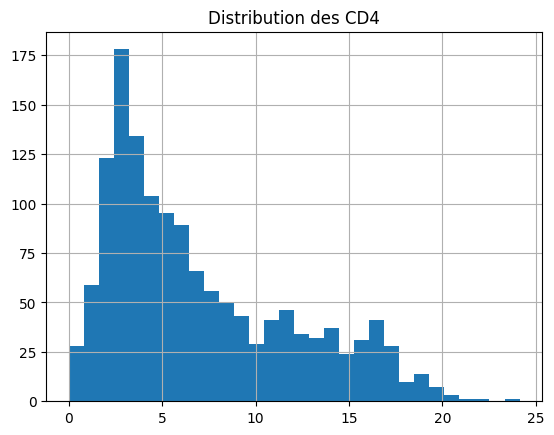

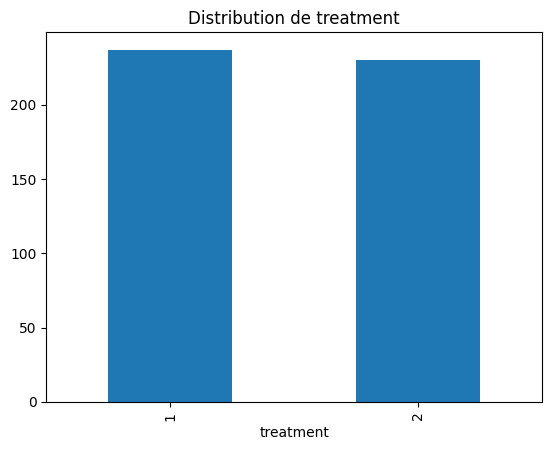

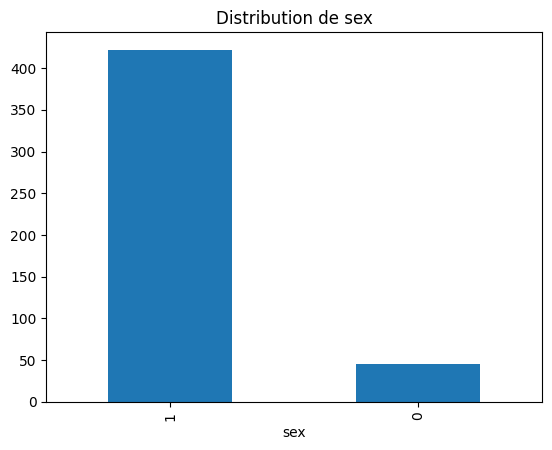

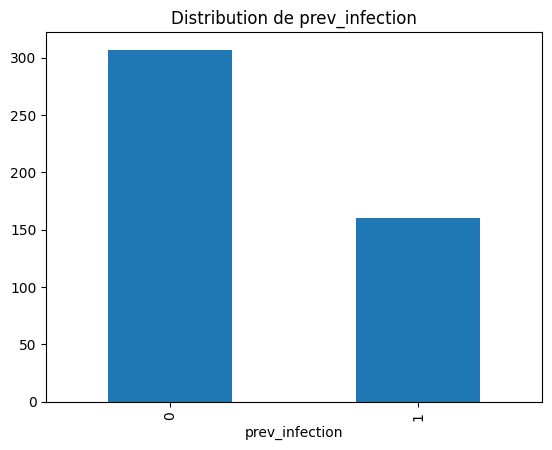

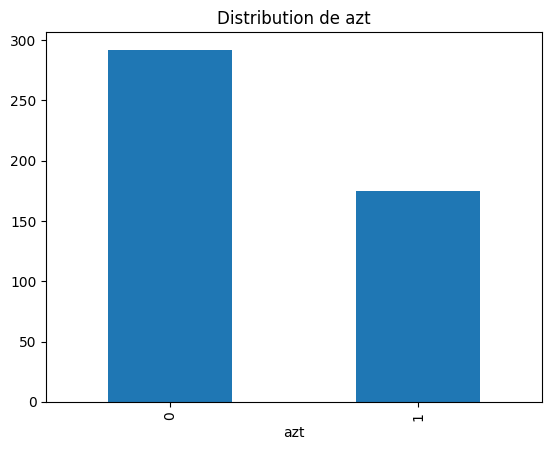

In [8]:
# Histogrammes pour les variables continues
data['cd4'].hist(bins=30)
plt.title('Distribution des CD4')
plt.show()

# Diagrammes en barres pour les variables catégoriques
for col in categorical_cols:
    unique_data[col].value_counts().plot(kind='bar')
    plt.title(f'Distribution de {col}')
    plt.show()


C:\Users\chouh\AppData\Local\Temp\ipykernel_8892\3598784372.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='treatment', y='time', data=unique_data, palette='pastel')


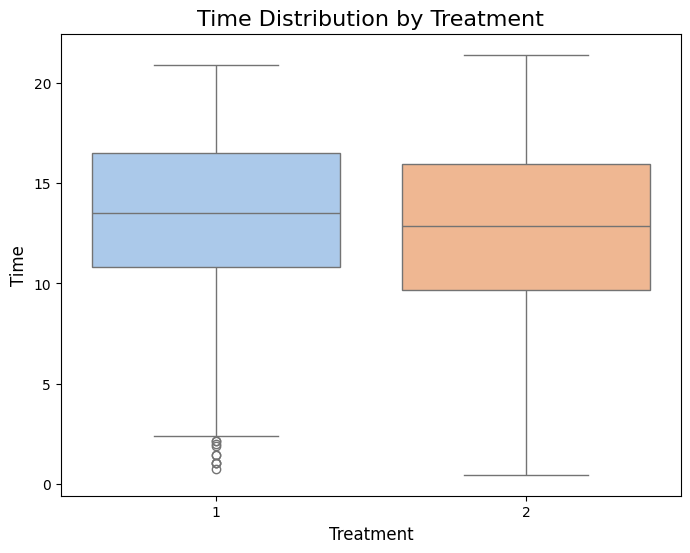

In [22]:
# Box Plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='treatment', y='time', data=unique_data, palette='pastel')
plt.title("Time Distribution by Treatment", fontsize=16)
plt.xlabel("Treatment", fontsize=12)
plt.ylabel("Time", fontsize=12)
plt.show()

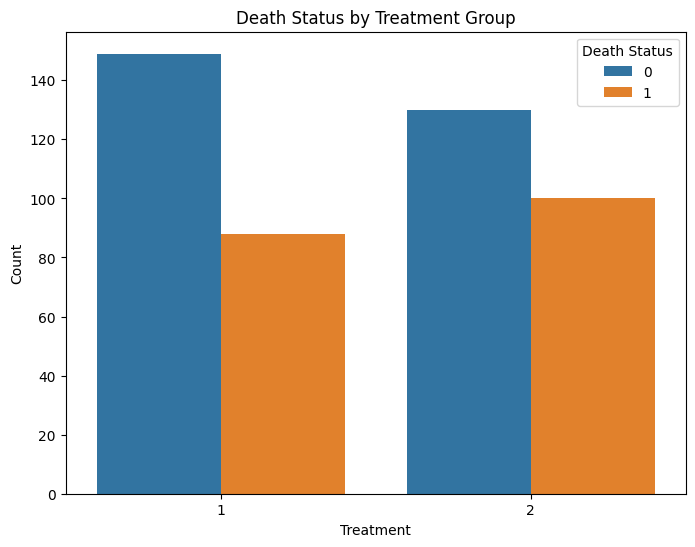

In [ ]:
# Créer un bar plot 
plt.figure(figsize=(8, 6))
sns.countplot(data=unique_data, x='treatment', hue='death', dodge=True)

# Ajout des labels et  titre
plt.title('Death Status by Treatment Group')
plt.xlabel('Treatment')
plt.ylabel('Count')
plt.legend(title='Death Status', labels=['0', '1'])

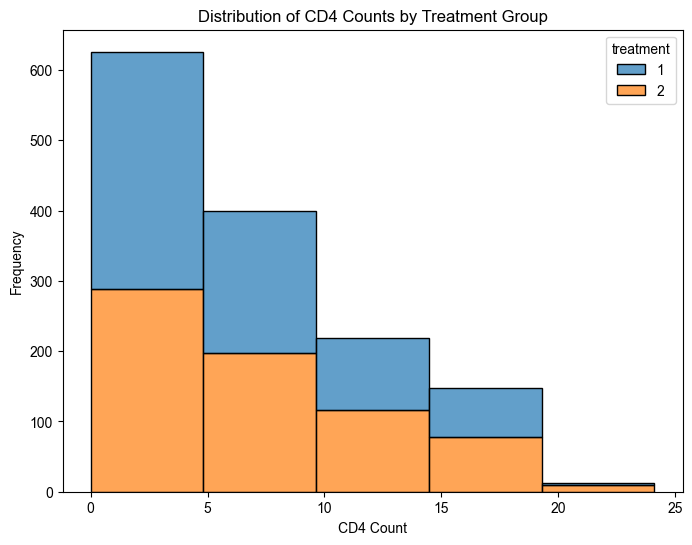

In [ ]:
# Créer un histogramme en utilisant seaborn
plt.figure(figsize=(8, 6))
sns.histplot(data=data, x='cd4', hue='treatment', multiple='stack', binwidth=5, alpha=0.7)

# Ajout du titres et les étiquettes des axes
plt.title('Distribution of CD4 Counts by Treatment Group')
plt.xlabel('CD4 Count')
plt.ylabel('Frequency')

# Appliquer un thème minimal
sns.set_theme(style="whitegrid")

# Afficher le graphique
plt.show()

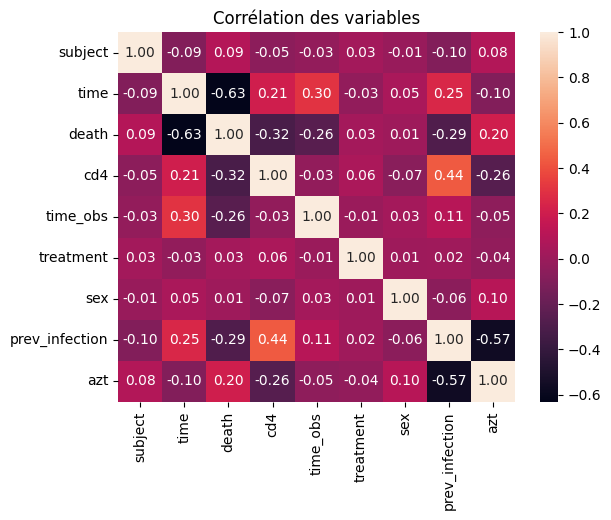

In [9]:
# Matrice de corrélation
sns.heatmap(data.corr(), annot=True, fmt=".2f")
plt.title('Corrélation des variables')
plt.show()


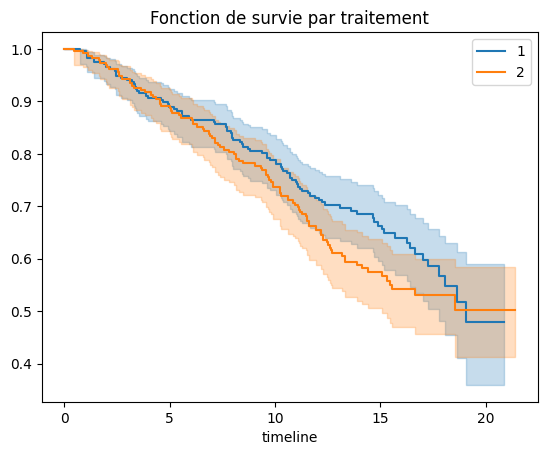

In [10]:
kmf = KaplanMeierFitter()

# Fonction de survie pour chaque traitement
for treatment in unique_data['treatment'].unique():
    mask = unique_data['treatment'] == treatment
    kmf.fit(unique_data['time'][mask], event_observed=unique_data['death'][mask] ,label=str(treatment))
    kmf.plot_survival_function()
    
plt.title('Fonction de survie par traitement')
plt.show()


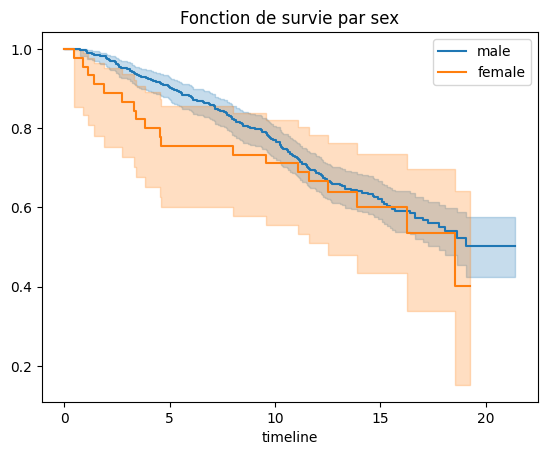

In [ ]:
kmf = KaplanMeierFitter()

# Fonction de survie pour chaque groupe de sexd
for sex in unique_data['sex'].unique():
    mask = unique_data['sex'] == sex
    kmf.fit(unique_data['time'][mask], event_observed=unique_data['death'][mask], label=str(sex))
    kmf.plot_survival_function()
    
plt.title('Fonction de survie par sex')
plt.show()

In [ ]:
from lifelines.statistics import logrank_test

# Comparaison des groupes
groups = data['treatment'].unique()
results = logrank_test(
    unique_data.loc[unique_data['treatment'] == groups[0], 'time'],
    unique_data.loc[unique_data['treatment'] == groups[1], 'time'],
    event_observed_0=unique_data.loc[unique_data['treatment'] == groups[0], 'death'],
    event_observed_1=unique_data.loc[unique_data['treatment'] == groups[1], 'death']
)
print('Log-Rank Test p-value:', results.p_value)


Log-Rank Test p-value: 0.15024319378036324


In [8]:
from lifelines.statistics import logrank_test

# Comparaison des groupes
groups = data['sex'].unique()
results = logrank_test(
    unique_data.loc[unique_data['sex'] == groups[0], 'time'],
    unique_data.loc[unique_data['sex'] == groups[1], 'time'],
    event_observed_0=unique_data.loc[unique_data['sex'] == groups[0], 'death'],
    event_observed_1=unique_data.loc[unique_data['sex'] == groups[1], 'death']
)
print('Log-Rank Test p-value:', results.p_value)

Log-Rank Test p-value: 0.1385473041592613


In [4]:
train, test = train_test_split(unique_data, test_size=0.2, stratify=unique_data['death'], random_state=42)



In [40]:
import jinja2
cox = CoxPHFitter()

# Ajuster le modèle sur l'ensemble d'entraînement
cox.fit(train, duration_col='time', event_col='death')
cox.print_summary()


<lifelines.CoxPHFitter: fitted with 373 total observations, 223 right-censored observations>
             duration col = 'time'
                event col = 'death'
      baseline estimation = breslow
   number of observations = 373
number of events observed = 150
   partial log-likelihood = -804.70
         time fit was run = 2024-12-02 22:22:10 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
azt             0.10      1.11      0.18           -0.25            0.45                0.78                1.57
prev_infection -1.41      0.24      0.27           -1.93           -0.89                0.14                0.41
sex            -0.21      0.81      0.30           -0.79            0.36                0.45                1.44
subject         0.00      1.00      0.00           -0.00            0.00                1.00                1.00
treatment       0.32      1.38      0.17           -0.00            0.64                1.00                1.90

                cmp to     z      p  -log2(p)
covariate                                    
azt               0.00  0.56   0.57      0.80
prev_infection    0.00 -5.29 <0.005     22.94
sex               0.00 -0.73   0.47      1.09
subject           0.00  0.57   0.57      0.81
treatment         0.00  1.93   0.05      4.23
---
Concordance = 0.65
Partial AIC = 1619.40
log-likelihood ratio test = 54.25 on 5 df
-log2(p) of ll-ratio test = 32.32

In [41]:
#Model de WeibullAFTFitter


from lifelines import WeibullAFTFitter

aft = WeibullAFTFitter()
aft.fit(train, duration_col='time', event_col='death')
aft.print_summary()


<lifelines.WeibullAFTFitter: fitted with 373 total observations, 223 right-censored observations>
             duration col = 'time'
                event col = 'death'
   number of observations = 373
number of events observed = 150
           log-likelihood = -631.90
         time fit was run = 2024-12-02 22:24:07 UTC

---
                        coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param   covariate                                                                                                       
lambda_ azt            -0.07      0.93      0.13           -0.32            0.18                0.73                1.20
        prev_infection  1.01      2.73      0.20            0.62            1.40                1.85                4.04
        sex             0.17      1.18      0.21           -0.25            0.58                0.78                1.78
        subject        -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
        treatment      -0.22      0.80      0.12           -0.45            0.01                0.64                1.01
        Intercept       3.25     25.82      0.29            2.69            3.81               14.73               45.29
rho_    Intercept       0.34      1.41      0.07            0.20            0.49                1.22                1.63

                        cmp to     z      p  -log2(p)
param   covariate                                    
lambda_ azt               0.00 -0.55   0.58      0.79
        prev_infection    0.00  5.05 <0.005     21.12
        sex               0.00  0.79   0.43      1.22
        subject           0.00 -0.59   0.56      0.85
        treatment         0.00 -1.88   0.06      4.05
        Intercept         0.00 11.34 <0.005     96.68
rho_    Intercept         0.00  4.66 <0.005     18.24
---
Concordance = 0.65
AIC = 1277.81
log-likelihood ratio test = 55.01 on 5 df
-log2(p) of ll-ratio test = 32.84

In [6]:
from sksurv.ensemble import RandomSurvivalForest

# Préparer les données pour Random Forest
from sksurv.util import Surv
train_y = Surv.from_dataframe("death", "time", train)
test_y = Surv.from_dataframe("death", "time", test)

rsf = RandomSurvivalForest(n_estimators=100, random_state=42)
rsf.fit(train.drop(columns=['time', 'death']), train_y)

# Prédictions sur les données de test
predictions = rsf.predict(test.drop(columns=['time', 'death']))


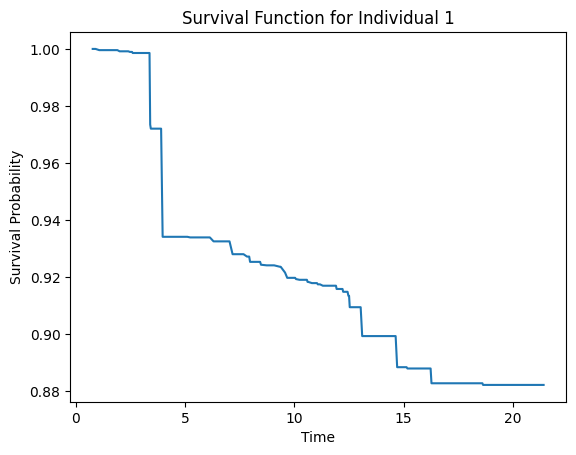

In [42]:
import matplotlib.pyplot as plt

#  récupérer la première fonction de survie
survival_prob = rsf.predict_survival_function(test.drop(columns=['time', 'death']))
time_points = survival_prob[0].x  # Points temporels
survival_values = survival_prob[0].y  # Probabilités de survie

# Tracer la courbe de survie
plt.plot(time_points, survival_values)
plt.title("Survival Function for Individual 1")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.show()


In [15]:
from sksurv.metrics import concordance_index_censored
c_index = concordance_index_censored(test_y['death'], test_y['time'], rsf.predict(test.drop(columns=['time', 'death'])))[0]
print(f"C-index: {c_index}")


C-index: 0.6030131826741997


In [43]:
from sksurv.ensemble import RandomSurvivalForest
from sklearn.inspection import permutation_importance
from sksurv.util import Surv
import pandas as pd
# Convertir les données en format compatible avec sksurv
train['death'] = train['death'].astype(bool)  
survival_data = Surv.from_dataframe("death", "time", train)

# Diviser les données en caractéristiques (X) et labels (y)
X_train = train.drop(columns=["time", "death"])
y_train = survival_data

# Initialiser et ajuster le modèle de forêt aléatoire pour la survie
rsf = RandomSurvivalForest(n_estimators=100, max_depth=10, random_state=42)
rsf.fit(X_train, y_train)

# Afficher un résumé du modèle
print("Random Survival Forest model trained.")
perm_importance = permutation_importance(rsf, X_train, y_train, n_repeats=10, random_state=42)

# Afficher l'importance des variables
print("Feature importances based on permutation importance:")
for feature, importance in zip(X_train.columns, perm_importance.importances_mean):
    print(f"{feature}: {importance:.4f}")


Random Survival Forest model trained.
Feature importances based on permutation importance:
azt: 0.0756
prev_infection: 0.1322
sex: 0.0201
subject: 0.2121
treatment: 0.1169
